# Complex III model
Comparing Gauthier and my complex III models

In [1]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D
using SteadyStateDiffEq
using OrdinaryDiffEq
using Plots
using ECMEDox
using ECMEDox: mM, μM, iVT, mV, Molar, Hz, ms, minute

# complex III and the Q cycle from Gauthier, 2013
# Adapted from Demin, 2001
function c3_gauthier(;
    dpsi=150mV,
    MT_PROT=1,
    O2=6μM,
    sox_m=0.001μM,
    h_i=exp10(-7) * Molar,
    h_m=exp10(-7.6) * Molar,
    ANTIMYCIN_BLOCK=0,
    MYXOTHIAZOLE_BLOCK=0,
    UQ = 3600μM,
    UQH2 = 400μM,
    cytc_ox = 208μM,
    cytc_rd = 325μM - cytc_ox,
    name = :c3_gauthier
    )

    @parameters begin
        rhoC3 = 325μM    ## Complex III activity
        rhoQo = rhoC3    ## Qo seat
        rhoQi = rhoC3    ## Qi seat
        Q_T = 4mM        ## Total CoQ pool
        EmSQp_QH2p = +290mV
        EmQp_SQp = -170mV
        EmQn_SQn = +50mV
        EmSQn_QH2n = +150mV
        EmbL_bHo = -40mV
        EmbL_bHr = EmbL_bHo - 60mV
        EmbH_bLo = +20mV
        EmbH_bLr = EmbH_bLo - 60mV
        EmFeS = +280mV
        Emcytc1 = +245mV
        Emcytc = +265mV
        EmO2 = -160mV
        K03_C3 = 1666.63Hz / mM
        KEQ3_C3 = exp(iVT * (EmFeS - EmSQp_QH2p)) ## -10mV
        K04_C3 = 50.67Hz / mM
        KEQ4_OX_C3 = exp(iVT * (EmbL_bHo - EmQp_SQp)) ## +130mV
        KEQ4_RD_C3 = exp(iVT * (EmbL_bHr - EmQp_SQp)) ## +70mV
        KD_Q = 22000Hz
        K06_C3 = 166.67Hz
        KEQ6_C3 = exp(iVT * (EmbH_bLo - EmbL_bHo)) ## +60mV
        K07_OX_C3 = 13.33Hz / mM
        K07_RD_C3 = 1.67Hz / mM
        KEQ7_OX_C3 = exp(iVT * (EmQn_SQn - EmbH_bLo)) ## +30mV
        KEQ7_RD_C3 = exp(iVT * (EmQn_SQn - EmbH_bLr)) ## +90mV
        K08_OX_C3 = 83.33Hz / mM
        K08_RD_C3 = 8.33Hz / mM
        KEQ8_OX_C3 = exp(iVT * (EmSQn_QH2n - EmbH_bLo)) ## +130mV
        KEQ8_RD_C3 = 9.4546   ## +60mV??? should be +190mV?
        K09_C3 = 832.48Hz / mM
        KEQ9_C3 = exp(iVT * (Emcytc1 - EmFeS))  ## -35mV
        K010_C3 = 28.33Hz / mM
        KEQ10_C3 = exp(iVT * (EmO2 - EmQp_SQp)) ## +10mV
        K33_C3 = 2469.13Hz / mM
        KEQ33_C3 = exp(iVT * (Emcytc - Emcytc1)) ## +20mV
    end

    # complex III inhibition by DOX and antimycin
    C3_CONC = rhoC3 * MT_PROT

    @variables begin
        Q_n(t)
        QH2_n(t)
        QH2_p(t)
        Q_p(t)
        SQp(t) = 0
        SQn(t) = 0
        fes_ox(t) = C3_CONC
        fes_rd(t) ## Conserved
        cytc1_ox(t) = C3_CONC
        cytc1_rd(t) ## Conserved
        cytb_1(t) = C3_CONC
        cytb_2(t) = 0
        cytb_3(t) = 0
        cytb_4(t) ## Conserved
        fracbLrd(t)
        fracbHrd(t)
        vROSC3(t)
        vHresC3(t)
    end

    # Split of electrical potentials
    δ₁_C3 = 0.5
    δ₂_C3 = 0.5
    δ₃_C3 = 0.5
    # Split of the electrical distance across the IMM
    α_C3 = 0.25
    β_C3 = 0.5
    γ_C3 = 0.25
    fHi = h_i * inv(1E-7Molar)
    fHm = h_m * inv(1E-7Molar)
    # QH2 + FeS = QH + FeS- + H+
    Qo_avail = (rhoQo - SQp) / rhoQo * (1 - MYXOTHIAZOLE_BLOCK)
    v3 = K03_C3 * (KEQ3_C3 * Qo_avail * fes_ox * QH2_p - fes_rd * SQp * fHi)
    # v4: QH + bL = Qp + bL- + H+
    el4 = exp(-iVT * α_C3 * δ₁_C3 * dpsi)
    er4 = exp(iVT * α_C3 * (1 - δ₁_C3) * dpsi)
    v4ox = K04_C3 * (KEQ4_OX_C3 * SQp * el4 * cytb_1 - Q_p * er4 * cytb_2 * fHi)
    v4rd = K04_C3 * (KEQ4_RD_C3 * SQp * el4 * cytb_3 - Q_p * er4 * cytb_4 * fHi)
    # v5 = Q diffusion (p-side -> n-side)
    v5 = KD_Q * (Q_p - Q_n)
    # v6 = bL to bH
    v6 = K06_C3 * (KEQ6_C3 * cytb_2 * exp(-iVT * β_C3 * δ₂_C3 * dpsi) - cytb_3 * exp(iVT * β_C3 * (1 - δ₂_C3) * dpsi))
    # v7 = bH to Qn; v8: bH to SQn
    Qi_avail = (rhoQi - SQn) / rhoQi * (1 - ANTIMYCIN_BLOCK)
    el7 = exp(-iVT * γ_C3 * δ₃_C3 * dpsi)
    er7 = exp(iVT * γ_C3 * (1 - δ₃_C3) * dpsi)
    qn = Q_n * Qi_avail
    qh2n = QH2_n * Qi_avail
    v7ox = K07_OX_C3 *  (KEQ7_OX_C3 * cytb_3 * qn * el7 - cytb_1 * SQn * er7)
    v7rd = K07_RD_C3 * (KEQ7_RD_C3 * cytb_4 * qn * el7 - cytb_2 * SQn * er7)
    v8ox = K08_OX_C3 * (KEQ8_OX_C3 * cytb_3 * SQn * fHm^2 * el7 - cytb_1 * qh2n * er7)
    v8rd = K08_RD_C3 * (KEQ8_RD_C3 * cytb_4 * SQn * fHm^2 * el7 - cytb_2 * qh2n * er7)
    # v9 = fes -> cytc1
    v9 = K09_C3 * (KEQ9_C3 * fes_rd * cytc1_ox - fes_ox * cytc1_rd)
    # v10: SQp + O2 -> O2- + Q
    v10 = K010_C3 * (KEQ10_C3 * O2 * SQp - sox_m * Q_p)
    # cytc1_2+  + cytc_3+ = cytc1_3+  + cytc_2+
    v33 = K33_C3 * (KEQ33_C3 * cytc1_rd * cytc_ox - cytc1_ox * cytc_rd)

    eqs = [
        C3_CONC ~ cytb_1 + cytb_2 + cytb_3 + cytb_4,
        C3_CONC ~ fes_ox + fes_rd,
        C3_CONC ~ cytc1_ox + cytc1_rd,
        Q_n ~ 0.5 * UQ,
        Q_p ~ 0.5 * UQ,
        QH2_n ~ 0.5 * UQH2,
        QH2_p ~ 0.5 * UQH2,
        fracbLrd ~ (cytb_2 + cytb_4) / C3_CONC,
        fracbHrd ~ (cytb_3 + cytb_4) / C3_CONC,
        # D(UQH2) ~ dQH2n + dQH2p,
        D(SQn) ~ v7ox + v7rd - v8ox - v8rd,
        D(SQp) ~ v3 - v10 - v4ox - v4rd,
        D(cytb_1) ~ v7ox + v8ox - v4ox,
        D(cytb_2) ~ v4ox + v7rd + v8rd - v6,
        D(cytb_3) ~ v6 - v4rd - v7ox - v8ox,
        # D(cytb_4) = v4rd - v7rd - v8rd
        D(fes_ox) ~ v9 - v3,
        D(cytc1_ox) ~ v33 - v9,
        vHresC3 ~ v3,
        vROSC3 ~ v10,
    ]
    return System(eqs, t; name)
end

# Semireverse bc1 complex model adapted from Gauthier, 2013
function c3_semireverse(;
    dpsi=150mV,
    MT_PROT=1,
    O2=6μM,
    sox_m=0.001μM,
    h_i=exp10(-7) * Molar,
    h_m=exp10(-7.6) * Molar,
    ANTIMYCIN_BLOCK=0,
    MYXOTHIAZOLE_BLOCK=0,
    UQ = 3600μM,
    UQH2 = 400μM,
    cytc_ox = 208μM,
    cytc_rd = 325μM - cytc_ox,
    name = :c3_semireverse)

    @parameters begin
        rhoC3 = 325μM    ## Complex III activity
        Q_T = 4mM        ## Total CoQ pool
        EmQ_C3 = +60mV   ## Ubiquinone redox potential at complex III Qo
        EmSQp_QH2p = +290mV
        EmQp_SQp = -170mV
        EmQn_SQn = +50mV
        EmSQn_QH2n = +150mV
        EmbL_bHo = -40mV
        EmbL_bHr = EmbL_bHo - 60mV
        EmbH_bLo = +20mV
        EmbH_bLr = EmbH_bLo - 60mV
        EmFeS = +280mV
        Emcytc1 = +245mV
        EmO2 = -160mV
        Emcytc = +255mV
        # QH2 + FeS + bL = Q + FeS- + bL- + 2Ho+
        K04_C3 = 50.67Hz / mM
        KEQ4_OX_C3 = exp(iVT * (EmFeS + EmbL_bHo - 2EmQ_C3))
        KEQ4_RD_C3 = exp(iVT * (EmFeS + EmbL_bHr - 2EmQ_C3))
        # bL- + bH = bL + bH-
        K06_C3 = 166.67Hz
        KEQ6_C3 = exp(iVT * (EmbH_bLo - EmbL_bHo)) ## +70mV
        # bH- + Q = bH + Q-
        K07_OX_C3 = 13.33Hz / mM
        K07_RD_C3 = 1.67Hz / mM
        KEQ7_OX_C3 = exp(iVT * (EmQn_SQn - EmbH_bLo)) ## +30mV
        KEQ7_RD_C3 = exp(iVT * (EmQn_SQn - EmbH_bLr)) ## +90mV
        # bH- + Q- + 2H+ = bH + QH2
        K08_OX_C3 = 83.33Hz / mM
        K08_RD_C3 = 8.33Hz / mM
        KEQ8_OX_C3 = exp(iVT * (EmSQn_QH2n - EmbH_bLo)) ## +130mV
        KEQ8_RD_C3 = exp(iVT * (EmSQn_QH2n - EmbH_bLr)) ## +190mV
        # FeS- + c1_3+ = FeS + c1_2+
        K09_C3 = 832.48Hz / mM
        KEQ9_C3 = exp(iVT * (Emcytc1 - EmFeS))  ## -40mV
        # bL- + Q = bL + Q-
        K010_C3 = 28.33Hz / mM
        KEQ10_OX_C3 = exp(iVT * (EmQp_SQp - EmbL_bHo)) ## -130mV
        KEQ10_RD_C3 = exp(iVT * (EmQp_SQp - EmbL_bHr)) ## -70mV
        # Q- + O2 = Q + O2-
        K011_C3 = 100Hz / mM
        # c1_2+ + c_3+ = c1_3+ + c_2+
        K33_C3 = 2469.13Hz / mM
        KEQ33_C3 = exp(iVT * (Emcytc - Emcytc1)) ## +20mV
    end

    # complex III inhibition by DOX and antimycin
    C3_INHIB = 1 - ANTIMYCIN_BLOCK
    C3_CONC = rhoC3 * MT_PROT

    @variables begin
        Q_n(t)
        QH2_n(t)
        QH2_p(t)
        Q_p(t)
        SQn(t) = 0
        SQp(t) = 0
        fes_ox(t) = C3_CONC
        fes_rd(t) ## Conserved
        cytc1_ox(t) = C3_CONC
        cytc1_rd(t) ## Conserved
        blo_bho(t) = C3_CONC
        blr_bho(t) = 0
        blo_bhr(t) = 0
        blr_bhr(t) ## Conserved
        fracbLrd(t)
        fracbHrd(t)
        vROSC3(t)
        vHresC3(t)
    end

    # Split of electrical potentials
    δ₁_C3 = 0.5
    δ₂_C3 = 0.5
    δ₃_C3 = 0.5
    # Split of the electrical distance across the IMM
    α_C3 = 0.25
    β_C3 = 0.5
    γ_C3 = 0.25
    # pH factors
    fHi = h_i * inv(1E-7Molar)
    fHm = h_m * inv(1E-7Molar)

    # QH2 + FeS + bL = Q + FeS- + bL- + 2Ho+
    # Lumped v3 and v4
    FeS = fes_ox / C3_CONC * (1 - MYXOTHIAZOLE_BLOCK)
    FeSm = fes_rd / C3_CONC * (1 - MYXOTHIAZOLE_BLOCK)
    el4 = exp(-iVT * α_C3 * δ₁_C3 * dpsi)
    er4 = exp(iVT * α_C3 * (1 - δ₁_C3) * dpsi)
    k4ox = K04_C3 * KEQ4_OX_C3 * el4
    k4rd = K04_C3 * KEQ4_RD_C3 * el4
    km4 = K04_C3 * er4 * fHi^2
    v4ox = k4ox * QH2_p * FeS * blo_bho - km4 * Q_p * FeSm * blr_bho
    v4rd = k4rd * QH2_p * FeS * blo_bhr - km4 * Q_p * FeSm * blr_bhr

    # bL- + bH = bL + bH-
    el6 = exp(-iVT * β_C3 * δ₂_C3 * dpsi)
    er6 = exp(iVT * β_C3 * (1 - δ₂_C3) * dpsi)
    k6 = K06_C3 * KEQ6_C3 * el6
    km6 = K06_C3 * er6
    v6 = k6 * blr_bho - km6 * blo_bhr

    # bH- + Q = bH + Q-
    Qi_avail = (C3_CONC - SQn) / C3_CONC * C3_INHIB
    el7 = exp(-iVT * γ_C3 * δ₃_C3 * dpsi)
    er7 = exp(iVT * γ_C3 * (1 - δ₃_C3) * dpsi)
    qn = Q_n * Qi_avail
    qh2n = QH2_n * Qi_avail
    k7ox = K07_OX_C3 * KEQ7_OX_C3 * el7
    k7rd = K07_RD_C3 * KEQ7_RD_C3 * el7
    km7ox = K07_OX_C3 * er7
    km7rd = K07_RD_C3 * er7
    k8ox = K08_OX_C3 * KEQ8_OX_C3 * el7 * fHm^2
    k8rd = K08_RD_C3 * KEQ8_RD_C3 * el7 * fHm^2
    km8ox = K08_OX_C3 * er7
    km8rd = K08_RD_C3 * er7
    v7ox = k7ox * blo_bhr * qn - km7ox * blo_bho * SQn
    v7rd = k7rd * blr_bhr * qn - km7rd * blr_bho * SQn
    v8ox = k8ox * blo_bhr * SQn - km8ox * blo_bho * qh2n
    v8rd = k8rd * blr_bhr * SQn - km8rd * blr_bho * qh2n

    # FeS- + c1_3+ = FeS + c1_2+
    v9 = K09_C3 * (KEQ9_C3 * fes_rd * cytc1_ox - fes_ox * cytc1_rd)

    # cytc1_2+  + cytc_3+ = cytc1_3+  + cytc_2+
    v33 = K33_C3 * (KEQ33_C3 * cytc1_rd * cytc_ox - cytc1_ox * cytc_rd)

    # bL- + Qp = bL + Qp-
    k10ox = K010_C3 * KEQ10_OX_C3 * er4
    k10rd = K010_C3 * KEQ10_RD_C3 * er4
    km10 = K010_C3 * el4
    v10ox = k10ox * Q_p * blr_bho - km10 * SQp * blo_bho
    v10rd = k10rd * Q_p * blr_bhr - km10 * SQp * blo_bhr

    # Qp- + O2 = Qp + O2-
    v11 = K011_C3 * SQp * O2

    eqs = [
        C3_CONC ~ blo_bho + blr_bho + blo_bhr + blr_bhr,
        C3_CONC ~ fes_ox + fes_rd,
        C3_CONC ~ cytc1_ox + cytc1_rd,
        Q_n ~ 0.5 * UQ,
        Q_p ~ 0.5 * UQ,
        QH2_n ~ 0.5 * UQH2,
        QH2_p ~ 0.5 * UQH2,
        fracbLrd ~ (blr_bho + blr_bhr) / C3_CONC,
        fracbHrd ~ (blo_bhr + blr_bhr) / C3_CONC,
        # D(UQH2) ~ dQH2n + dQH2p,
        D(SQn) ~ v7ox + v7rd - v8ox - v8rd,
        D(SQp) ~ v10ox + v10rd - v11,
        D(blo_bho) ~ v7ox + v8ox - v4ox + v10ox,
        D(blr_bho) ~ v4ox + v7rd + v8rd - v6 - v10ox,
        D(blo_bhr) ~ v6 - v4rd - v7ox - v8ox + v10rd,
        # D(blr_bhr) = v4rd - v7rd - v8rd - v10rd
        D(fes_ox) ~ v9 - v4ox - v4rd,
        D(cytc1_ox) ~ v33 - v9,
        vHresC3 ~ v4ox + v4rd,
        vROSC3 ~ v11,
    ]
    return System(eqs, t; name)
end

# Complex III repulsion model
# Reduced heme bL blocks QH2 oxidation at Qo site due to repulsion of bL- and Q-
# SQp is unstable (Em(Q/SQ) = -300mV)
function c3_repulsion(;
    dpsi=150mV,
    MT_PROT=1,
    O2=6μM,
    sox_m=0.001μM,
    h_i=exp10(-7) * Molar,
    h_m=exp10(-7.6) * Molar,
    ANTIMYCIN_BLOCK=0,
    MYXOTHIAZOLE_BLOCK=0,
    UQ = 3600μM,
    UQH2 = 400μM,
    cytc_ox = 208μM,
    cytc_rd = 325μM - cytc_ox,
    name = :c3_repulse
    )

    @parameters begin
        rhoC3 = 325μM    ## Complex III activity
        Q_T = 4mM        ## Total CoQ pool
        EmQp = +60mV
        EmSQp_QH2p = +400mV
        EmQp_SQp = 2EmQp - EmSQp_QH2p
        EmQn_SQn = +50mV
        EmSQn_QH2n = +150mV
        EmbL_bHo = -40mV
        EmbL_bHr = EmbL_bHo - 60mV
        EmbH_bLo = +20mV
        EmbH_bLr = EmbH_bLo - 60mV
        EmFeS = +280mV
        Emcytc1 = +245mV
        EmO2 = -160mV
        Emcytc = +265mV
        K03_C3 = 2E5Hz / mM ## 1666.63Hz / mM
        KEQ3_C3 = exp(iVT * (EmFeS - EmSQp_QH2p)) ## ~ 0.01
        K04_C3 = 50.67Hz / mM
        KEQ4_OX_C3 = exp(iVT * (EmbL_bHo - EmQp_SQp))
        KEQ4_RD_C3 = exp(iVT * (EmbL_bHr - EmQp_SQp))
        KD_Q = 22000Hz
        K06_C3 = 10000Hz ## from 166.67Hz
        KEQ6_C3 = exp(iVT * (EmbH_bLo - EmbL_bHo))
        K07_OX_C3 = 13.33Hz / mM
        K07_RD_C3 = 1.67Hz / mM
        KEQ7_OX_C3 = exp(iVT * (EmQn_SQn - EmbH_bLo))
        KEQ7_RD_C3 = exp(iVT * (EmQn_SQn - EmbH_bLr))
        K08_OX_C3 = 83.33Hz / mM
        K08_RD_C3 = 8.33Hz / mM
        KEQ8_OX_C3 = exp(iVT * (EmSQn_QH2n - EmbH_bLo))
        KEQ8_RD_C3 = exp(iVT * (EmSQn_QH2n - EmbH_bLr))
        K09_C3 = 832.48Hz / mM
        KEQ9_C3 = exp(iVT * (Emcytc1 - EmFeS))
        K010_C3 = 28.33Hz / mM
        KEQ10_C3 = exp(iVT * (EmO2 - EmQp_SQp))
        K33_C3 = 2469.13Hz / mM
        KEQ33_C3 = exp(iVT * (Emcytc - Emcytc1))
    end

    # complex III inhibition by DOX and antimycin
    C3_CONC = rhoC3 * MT_PROT

    @variables begin
        Q_n(t)
        QH2_n(t)
        QH2_p(t)
        Q_p(t)
        SQp(t) = 0
        SQn(t) = 0
        fes_ox(t) = C3_CONC
        fes_rd(t) ## Conserved
        cytc1_ox(t) = C3_CONC
        cytc1_rd(t) ## Conserved
        blo_bho(t) = C3_CONC
        blo_bhr(t) = 0
        blr_bho(t) = 0
        blr_bhr(t) ## Conserved
        fracbLrd(t)
        fracbHrd(t)
        vROSC3(t)
        vHresC3(t)
    end

    # Split of electrical potentials
    δ₁_C3 = 0.5
    δ₂_C3 = 0.5
    δ₃_C3 = 0.5
    # Split of the electrical distance across the IMM
    α_C3 = 0.25
    β_C3 = 0.5
    γ_C3 = 0.25
    fHi = h_i * inv(1E-7Molar)
    fHm = h_m * inv(1E-7Molar)
    # QH2 + FeS = Q- + FeS- + H+
    Qo_avail = (C3_CONC - SQp) / C3_CONC * (1 - fracbLrd) * (1 - MYXOTHIAZOLE_BLOCK)
    v3 = K03_C3 * (KEQ3_C3 * Qo_avail * fes_ox * QH2_p - fes_rd * SQp * fHi^2)
    # Q- + bL = Qp + bL-
    el4 = exp(-iVT * α_C3 * δ₁_C3 * dpsi)
    er4 = exp(iVT * α_C3 * (1 - δ₁_C3) * dpsi)
    v4ox = K04_C3 * (KEQ4_OX_C3 * SQp * el4 * blo_bho - Q_p * er4 * blr_bho)
    v4rd = K04_C3 * (KEQ4_RD_C3 * SQp * el4 * blo_bhr - Q_p * er4 * blr_bhr)
    # v5 = Q diffusion (p-side -> n-side)
    v5 = KD_Q * (Q_p - Q_n)
    # v6 = bL to bH
    el6 = exp(-iVT * β_C3 * δ₂_C3 * dpsi)
    er6 = exp(iVT * β_C3 * (1 - δ₂_C3) * dpsi)
    v6 = K06_C3 * (KEQ6_C3 * blr_bho * el6 - blo_bhr * er6)
    # v7 = bH to Qn; v8: bH to SQn
    Qi_avail = (C3_CONC - SQn) / C3_CONC * (1 - ANTIMYCIN_BLOCK)
    el7 = exp(-iVT * γ_C3 * δ₃_C3 * dpsi)
    er7 = exp(iVT * γ_C3 * (1 - δ₃_C3) * dpsi)
    qn = Q_n * Qi_avail
    qh2n = QH2_n * Qi_avail
    v7ox = K07_OX_C3 * (KEQ7_OX_C3 * blo_bhr * qn * el7 - blo_bho * SQn * er7)
    v7rd = K07_RD_C3 * (KEQ7_RD_C3 * blr_bhr * qn * el7 - blr_bho * SQn * er7)
    v8ox = K08_OX_C3 * (KEQ8_OX_C3 * blo_bhr * SQn * fHm^2 * el7 - blo_bho * qh2n * er7)
    v8rd = K08_RD_C3 * (KEQ8_RD_C3 * blr_bhr * SQn * fHm^2 * el7 - blr_bho * qh2n * er7)
    # v9 = fes -> cytc1
    v9 = K09_C3 * (KEQ9_C3 * fes_rd * cytc1_ox - fes_ox * cytc1_rd)
    # SQp + O2 -> O2- + Q
    v10 = K010_C3 * (KEQ10_C3 * O2 * SQp - sox_m * Q_p)
    # cytc1_2+  + cytc_3+ = cytc1_3+  + cytc_2+
    v33 = K33_C3 * (KEQ33_C3 * cytc1_rd * cytc_ox - cytc1_ox * cytc_rd)

    eqs = [
        C3_CONC ~ blo_bho + blr_bho + blo_bhr + blr_bhr,
        C3_CONC ~ fes_ox + fes_rd,
        C3_CONC ~ cytc1_ox + cytc1_rd,
        Q_n ~ 0.5 * UQ,
        Q_p ~ 0.5 * UQ,
        QH2_n ~ 0.5 * UQH2,
        QH2_p ~ 0.5 * UQH2,
        fracbLrd ~ (blr_bho + blr_bhr) / C3_CONC,
        fracbHrd ~ (blo_bhr + blr_bhr) / C3_CONC,
        # D(UQH2) ~ dQH2n + dQH2p,
        D(SQn) ~ v7ox + v7rd - v8ox - v8rd,
        D(SQp) ~ v3 - v10 - v4ox - v4rd,
        D(blo_bho) ~ v7ox + v8ox - v4ox,
        D(blr_bho) ~ v4ox + v7rd + v8rd - v6,
        D(blo_bhr) ~ v6 - v4rd - v7ox - v8ox,
        # D(blr_bhr) = v4rd - v7rd - v8rd
        D(fes_ox) ~ v9 - v3,
        D(cytc1_ox) ~ v33 - v9,
        vHresC3 ~ v6,
        vROSC3 ~ v10,
    ]
    return System(eqs, t; name)
end

c3_repulsion (generic function with 1 method)

In [2]:
@parameters begin
    UQ = 3600μM
    UQH2 = 400μM
    dpsi = 150mV
    cytc_ox = 208μM
    cytc_rd = 325μM - cytc_ox
    sox_m = 0.01μM
end

6-element Vector{Symbolics.Num}:
      UQ
    UQH2
    dpsi
 cytc_ox
 cytc_rd
   sox_m

In [3]:
gsys = c3_gauthier(;dpsi, cytc_ox, cytc_rd, UQ, UQH2, sox_m) |> mtkcompile
nsys = c3_repulsion(;dpsi, cytc_ox, cytc_rd, UQ, UQH2, sox_m) |> mtkcompile
rsys = c3_semireverse(;dpsi, cytc_ox, cytc_rd, UQ, UQH2, sox_m) |> mtkcompile

┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/v

Model c3_semireverse:
Equations (7):
  7 standard: see equations(c3_semireverse)
Unknowns (7): see unknowns(c3_semireverse)
  cytc1_ox(t) [defaults to rhoC3]
  fes_ox(t) [defaults to rhoC3]
  blo_bhr(t) [defaults to 0]
  blr_bho(t) [defaults to 0]
  ⋮
Parameters (38): see parameters(c3_semireverse)
  K08_OX_C3 [defaults to 8.333e-5]
  K07_RD_C3 [defaults to 1.67e-6]
  EmbL_bHr [defaults to -60 + EmbL_bHo]
  K06_C3 [defaults to 0.16667]
  ⋮
Observed (11): see observed(c3_semireverse)

In [4]:
prob_g = SteadyStateProblem(gsys, [])
prob_n = SteadyStateProblem(nsys, [nsys.EmSQp_QH2p => +400mV, nsys.EmQp => 60mV, nsys.K010_C3 => 33Hz / mM])
prob_r = SteadyStateProblem(rsys, [rsys.K010_C3 => 4Hz / mM, rsys.K011_C3 => 100Hz / mM, rsys.K04_C3 => 50Hz / mM])
alg = DynamicSS(Rodas5P())
ealg = EnsembleThreads()
extract(sim, k) = map(s -> s[k], sim)

extract (generic function with 1 method)

## Varying MMP

  4.856241 seconds (28.76 M allocations: 1.486 GiB, 7.56% gc time, 171.78% compilation time)
  2.912938 seconds (15.74 M allocations: 867.859 MiB, 19.30% gc time, 169.31% compilation time)
  2.871038 seconds (15.91 M allocations: 841.798 MiB, 9.81% gc time, 170.05% compilation time)


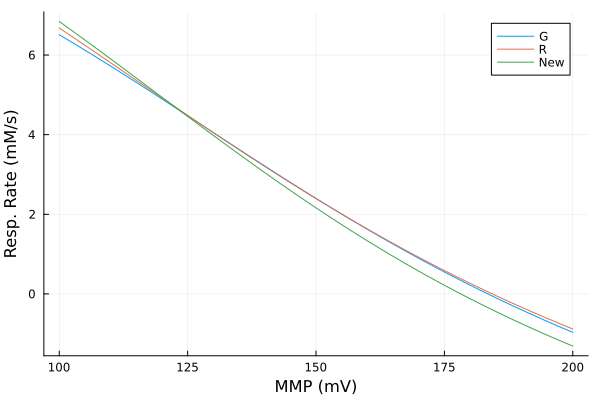

In [5]:
dpsirange = 100mV:1mV:200mV
alter_dpsi = (prob, i, repeat) -> begin
    prob.ps[dpsi] = dpsirange[i]
    prob
end

eprob_g = EnsembleProblem(prob_g; prob_func=alter_dpsi)
eprob_n = EnsembleProblem(prob_n; prob_func=alter_dpsi)
eprob_r = EnsembleProblem(prob_r; prob_func=alter_dpsi)
@time sim_g = solve(eprob_g, alg, ealg; trajectories=length(dpsirange), abstol=1e-8, reltol=1e-8)
@time sim_n = solve(eprob_n, alg, ealg; trajectories=length(dpsirange), abstol=1e-8, reltol=1e-8)
@time sim_r = solve(eprob_r, alg, ealg; trajectories=length(dpsirange), abstol=1e-8, reltol=1e-8)

xs = dpsirange
ys = [extract(sim_g, gsys.vHresC3) extract(sim_r, rsys.vHresC3) extract(sim_n, nsys.vHresC3)]
plot(xs, ys, xlabel="MMP (mV)", ylabel="Resp. Rate (mM/s)", label=["G" "R" "New"])

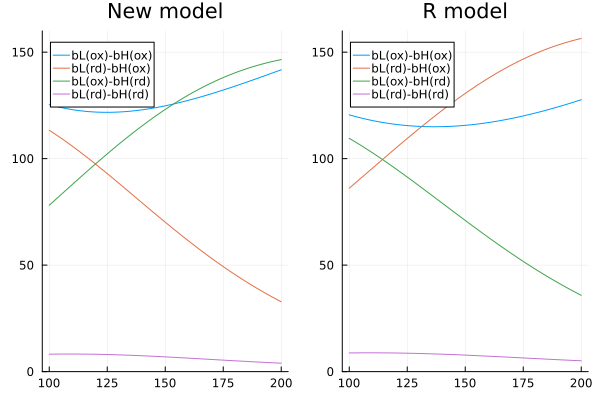

In [6]:
plot(xs, extract(sim_n, nsys.blo_bho), label="bL(ox)-bH(ox)", title="New model")
plot!(xs, extract(sim_n, nsys.blo_bhr), label="bL(rd)-bH(ox)")
plot!(xs, extract(sim_n, nsys.blr_bho), label="bL(ox)-bH(rd)")
pl1 = plot!(xs, extract(sim_n, nsys.blr_bhr), label="bL(rd)-bH(rd)", ylim=(0, 160))
plot(xs, extract(sim_r, rsys.blo_bho), label="bL(ox)-bH(ox)", title = "R model")
plot!(xs, extract(sim_r, rsys.blr_bho), label="bL(rd)-bH(ox)")
plot!(xs, extract(sim_r, rsys.blo_bhr), label="bL(ox)-bH(rd)")
pl2 = plot!(xs, extract(sim_r, rsys.blr_bhr), label="bL(rd)-bH(rd)", ylim=(0, 160))
plot(pl1, pl2)

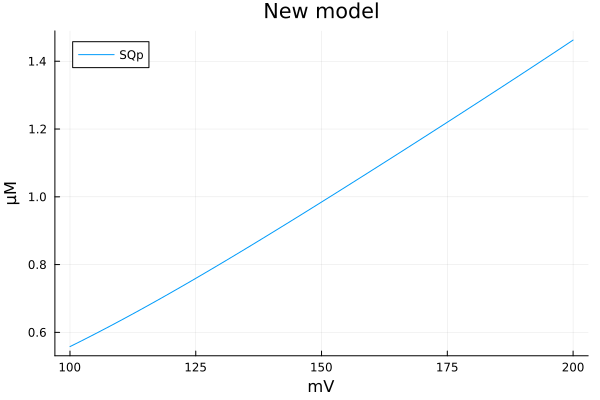

In [7]:
plot(dpsirange, extract(sim_n, nsys.SQp), label="SQp", title="New model", xlabel="mV", ylabel="μM")

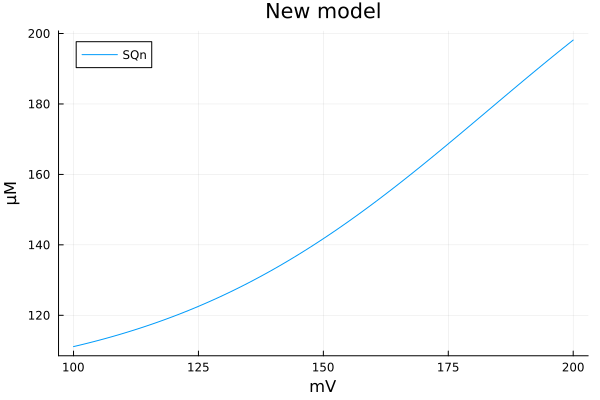

In [8]:
plot(dpsirange, extract(sim_n, nsys.SQn), label="SQn", title="New model", xlabel="mV", ylabel="μM")

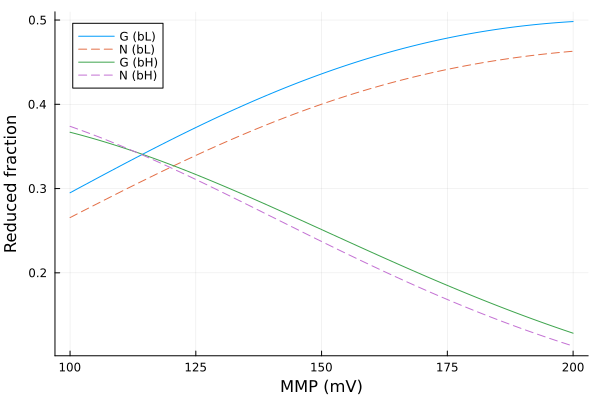

In [9]:
ys = [extract(sim_g, gsys.fracbLrd) extract(sim_n, nsys.fracbLrd) extract(sim_g, gsys.fracbHrd) extract(sim_n, nsys.fracbHrd)]
plot(xs, ys, xlabel="MMP (mV)", ylabel="Reduced fraction", label=["G (bL)" "N (bL)" "G (bH)" "N (bH)"], line=[:solid :dash :solid :dash])

ROS generation rate: 0.005 ~ 0.020 mM/s

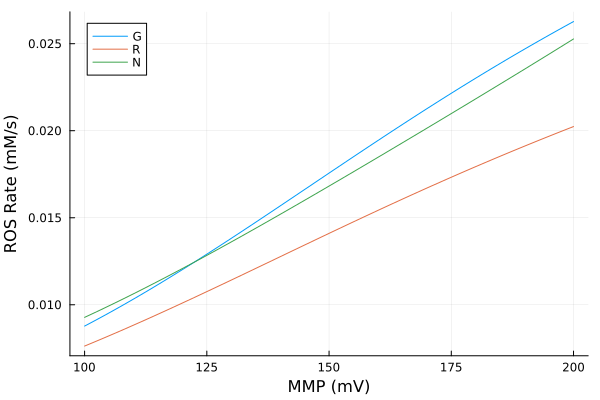

In [10]:
ys = [extract(sim_g, gsys.vROSC3) extract(sim_r, rsys.vROSC3) extract(sim_n, nsys.vROSC3)]
plot(xs, ys, xlabel="MMP (mV)", ylabel="ROS Rate (mM/s)", label=["G" "R" "N"])

## Varying UQH2

In [11]:
qh2range = 10μM:10μM:3990μM
alter_qh2 = (prob, i, repeat) -> begin
    prob.ps[UQH2] = qh2range[i]
    prob.ps[UQ] = 4000μM - prob.ps[UQH2]
    prob
end

eprob_g = EnsembleProblem(prob_g; prob_func=alter_qh2)
eprob_n = EnsembleProblem(prob_n; prob_func=alter_qh2)
eprob_r = EnsembleProblem(prob_r; prob_func=alter_qh2)
@time sim_g = solve(eprob_g, alg, ealg; trajectories=length(qh2range), abstol=1e-8, reltol=1e-8)
@time sim_n = solve(eprob_n, alg, ealg; trajectories=length(qh2range), abstol=1e-8, reltol=1e-8)
@time sim_r = solve(eprob_r, alg, ealg; trajectories=length(qh2range), abstol=1e-8, reltol=1e-8)

  1.013302 seconds (11.37 M allocations: 625.389 MiB, 18.94% gc time, 29.05% compilation time)
  1.823223 seconds (11.89 M allocations: 774.942 MiB, 48.73% gc time, 12.34% compilation time)
  1.193293 seconds (11.57 M allocations: 635.397 MiB, 24.84% gc time, 22.21% compilation time)


EnsembleSolution Solution of length 399 with uType:
SciMLBase.NonlinearSolution{_A, _B, _C, _D, SciMLBase.SteadyStateProblem{Vector{Float64}, true, ModelingToolkit.MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 3, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xc51b65e2, 0x421b5b64, 0x53a8bbbf, 0xa056a6c9, 0x1294a9e5), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x87ab45c7, 0xc599f68c, 0x587c3b2f, 0xa378a8a7, 0xab7e3080), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunc

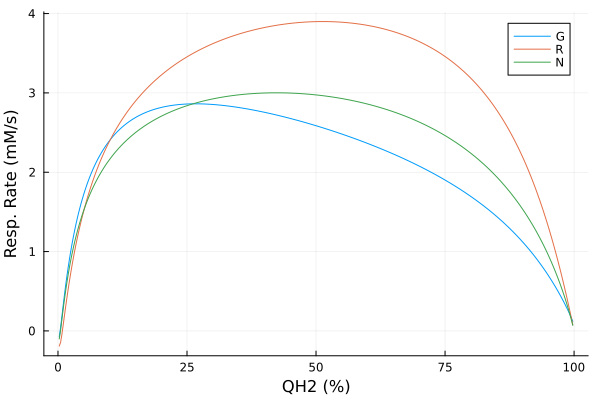

In [12]:
xs = qh2range ./ 4000μM .* 100
ys = [extract(sim_g, gsys.vHresC3) extract(sim_r, rsys.vHresC3) extract(sim_n, nsys.vHresC3)]
plot(xs, ys, xlabel="QH2 (%)", ylabel="Resp. Rate (mM/s)", label=["G" "R" "N"])

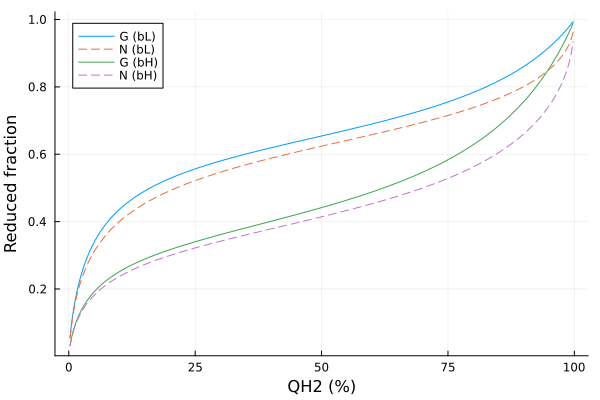

In [13]:
ys = [extract(sim_g, gsys.fracbLrd) extract(sim_n, nsys.fracbLrd) extract(sim_g, gsys.fracbHrd) extract(sim_n, nsys.fracbHrd)]
plot(xs, ys, xlabel="QH2 (%)", ylabel="Reduced fraction", label=["G (bL)" "N (bL)" "G (bH)" "N (bH)"], line=[:solid :dash :solid :dash])

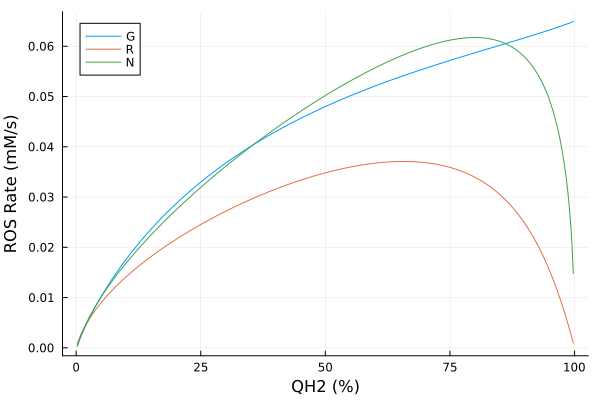

In [14]:
ys = [extract(sim_g, gsys.vROSC3) extract(sim_r, rsys.vROSC3) extract(sim_n, nsys.vROSC3)]
plot(xs, ys, xlabel="QH2 (%)", ylabel="ROS Rate (mM/s)", label=["G" "R" "N"])

In [15]:
ys = [extract(sim_g, gsys.SQp) extract(sim_r, rsys.SQp) extract(sim_n, nsys.SQp)]

399×3 Matrix{Float64}:
   3.75078   1.41217  0.0574884
   6.65507   2.56853  0.103164
   9.29678   3.59749  0.143711
  11.7823    4.54158  0.180907
  14.1555    5.41951  0.215625
  16.4399    6.24505  0.248394
  18.6505    7.02694  0.279567
  20.7976    7.77139  0.3094
  22.8886    8.48309  0.338083
  24.9294    9.16649  0.365765
   ⋮                  
 259.688    12.9704   2.1381
 260.038    11.6569   2.04611
 260.392    10.312    1.94416
 260.749     8.93667  1.82999
 261.111     7.529    1.70035
 261.478     6.08861  1.55024
 261.853     4.61533  1.37131
 262.238     3.10909  1.14729
 262.646     1.57025  0.836363

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*